In [2]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import altair as alt
import json
import itertools as it

In [3]:
# Importing the plotly packages
import plotly.graph_objects as go
import plotly
import chart_studio.plotly as py

In [4]:
ds = pd.read_csv('S1SubActivities_preprocessed.csv', index_col = None)
ds.start = pd.to_datetime(ds.start, format='%Y-%m-%d %H:%M:%S')
ds.end = pd.to_datetime(ds.end, format='%Y-%m-%d %H:%M:%S')
ds = ds.sort_values('start')
ds.reset_index(drop = True, inplace = True)

In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 4 columns):
subActNum    2772 non-null int64
subAct       2772 non-null object
start        2772 non-null datetime64[ns]
end          2772 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 86.8+ KB


In [106]:
#ds = ds[:1000]
#ds.head(5)

,subActNum,subAct,start,end
0,67,Cabinet,2003-03-27 06:43:40,2003-03-27 06:43:43
1,100,Toilet Flush,2003-03-27 06:44:06,2003-03-27 07:12:41
2,101,Light switch,2003-03-27 06:44:20,2003-03-27 07:46:34
3,57,Medicine cabinet,2003-03-27 06:44:35,2003-03-27 06:44:48
4,58,Medicine cabinet,2003-03-27 06:44:36,2003-03-27 06:44:48


# Problem Statement

**If start EVENTA between X and Y on a WD/WE the PR that I will start EVENTB within Z minutes is Q.**

>_If I switch on the bathroom light switch between 6am and 7am on a weekday, the probability that I will use my razor is X._

## Relationships

### Intersection
<pre>
|----EventA----|  <br>
            |---EventB---|   
</pre>

### Separate
<pre>
|----EventA----|  <br>
                    |---EventB---|   
</pre>

### Enclosed
<pre>
|----------EventA----------|  <br>
           |---EventB---|   
</pre>

### Equal
<pre>
       |---EventA---|  <br>
       |---EventB---|   
</pre>

### More?

---
## Pr(EventA delta eventB)

### Delta Negative
<pre>
|----EventA----|  <br>
                -Gap- <br>
                     |---EventB---|   
</pre>

### Delta Positive
<pre>
|------EventA------|  <br>
            -Union-   <br>
            |---EventB---|   
</pre>

### Delta Zero
<pre>
|--EventA--|  <br>

           |------EventB------|   
</pre>

### Equal Start
<pre>
|--EventA--|  <br>

|------EventB------|   
</pre>

**Input A:** S1SubActivities_preprocessed.csv

| Event    | EventStart | EventEnd   |        
|:--------:|:--------:  | :--------: |        
| 100      | dateTime   | dateTime   |        
| 101      | dateTime   | dateTime   |        
| 104      | dateTime   | dateTime   |  
| 105      | dateTime   | dateTime   |  

**Input B:** dsCombin2n

| EventA   | EventB  | 
|:--------:|:-------:| 
| 100      | 101     | 
| 100      | 104     | 
| 100      | 105     | 
| 100      | 106     | 

**Function:** def id_delta(InputA, InputB)  <br>
**Output:**

| EventA   | EventB   |  Ev.A Start | Ev.A End | Ev.B Start | Ev.B End | Delta    | Descriptor |
|:--------:|:--------:| :--------:  | :------: |:--------:  | :------: | :------: | :------:   |
| 100      | 101      |  dateTime   | dateTime | dateTime   | dateTime | -4       | Gap        |
| 100      | 104      |  dateTime   | dateTime | dateTime   | dateTime | 92       | Union      |
| 100      | 105      |  dateTime   | dateTime | dateTime   | dateTime | 0        | Zero       | 
| 100      | 106      |  dateTime   | dateTime | dateTime   | dateTime | ???      | EqualStart | 

**Function:** def add_temporalFeatures(): <br>
**Output:**

| EventA| EventB| Ev.A Start| Ev.A End| Ev.B Start|Ev.B End|Delta   | Descriptor | WendWday|Hour  |TimeofDay|
|:-----:|:-----:|:--------: | :------:|:--------: |:------:|:------:| :------:   | :------:|:----:|:------: |
| 100   | 101   | dateTime  | dateTime| dateTime  |dateTime|-4      | Gap        | weekday | 6:00 |6Till8   |
| 100   | 104   | dateTime  | dateTime| dateTime  |dateTime|92      | Union      | weekend |12:00 |12Till14 |
| 100   | 105   | dateTime  | dateTime| dateTime  |dateTime|0       | Zero       | weekday |15:00 |15Till17 |
| 100   | 106   | dateTime  | dateTime| dateTime  |dateTime|???     | EqualStart | weekday |15:00 |15Till17 |

### def id_delta(InputA, InputB)

* WHERE event A is followed/ union/ gap (first )  by event B
* IF (event A end < event B start)
* SUM (event B start - event A end) = delta
* Add delta attribute to df
* RETURN df

---

1. Equal Start
2. Delta positive (the highest)
3. Delta Zero (the first)
4. Delta Negative (closest to zero)


And nearest 5 

In [6]:
import datetime as dt

def id_delta(events, n=1, delta_threshold=dt.timedelta(-99)):
    nns = []
    for row in events.itertuples():
        #print(row)
        start_time = getattr(row, 'start')
        end_time = getattr(row, 'end')
        subActNum = getattr(row, 'subActNum')
        row_index = getattr(row, 'Index')
        
        nn = events[(events.start >= start_time) & 
                    (events.index != row_index) & 
                    ((start_time - events.start) > delta_threshold)][:n]
        #print(len(nn))
        ordered = pd.DataFrame()
        ordered['Dummy'] = nn['subActNum']
        ordered['EventA'] = subActNum
        ordered['EventB'] = nn['subActNum']
        ordered['EvA_Start'] = start_time
        ordered['EvB_Start'] = nn['start']
        ordered['EvA_End'] = end_time
        ordered['EvB_End'] = nn['end']
        del ordered['Dummy']
        nns.append(ordered)
  
    #print(nns)
    result = pd.concat(nns)

    result['Delta'] = np.where(result['EvA_Start']==result['EvB_Start'], 
                               None, 
                               (result['EvA_End'] - result['EvB_Start']) / 1000000000)
    return result

In [7]:
ds_1n_25s = id_delta(ds, 1, dt.timedelta(0,-25))

In [71]:
ds_1n_900s = id_delta(ds, 1, dt.timedelta(0,-900))

In [107]:
ds_12n_900s = id_delta(ds, 12, dt.timedelta(0,-900))

In [75]:
ds_5n_200s = id_delta(ds, 5, dt.timedelta(0,-200))

In [115]:
ds_5n_15s = id_delta(ds, 5, dt.timedelta(0,-15))

In [15]:
# Must also install JupyerLab plotly extension
# https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/plotly-extension 

In [40]:
data.head(n=2)

,EventA,EventB,EvA_Start,EvB_Start,EvA_End,EvB_End,Delta
1,67,100,2003-03-27 06:43:40,2003-03-27 06:44:06,2003-03-27 06:43:43,2003-03-27 07:12:41,-23
2,67,101,2003-03-27 06:43:40,2003-03-27 06:44:20,2003-03-27 06:43:43,2003-03-27 07:46:34,-37


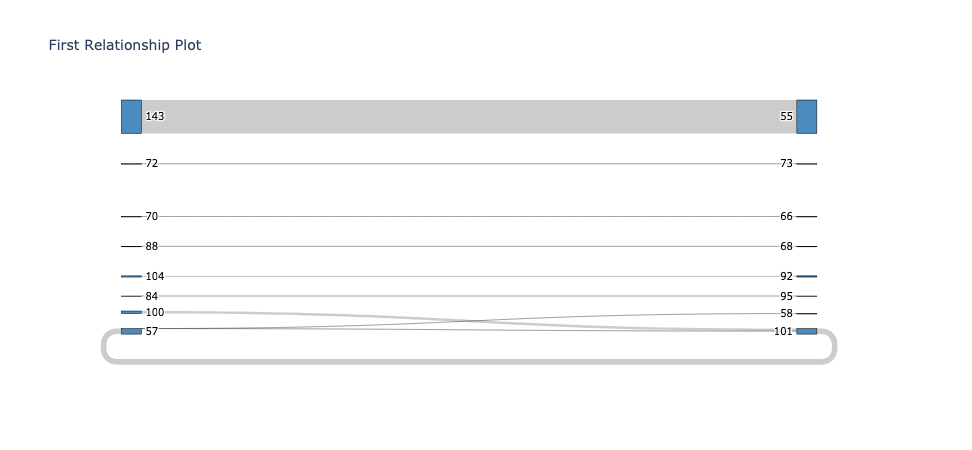

In [70]:
fig = genSankey(ds_1n_25s, cat_cols=['EventA', 'EventB'], value_cols='Delta', title='First Relationship Plot')
go.Figure(fig)      #plotly.offline.plot(fig, validate=False) - export to HTML

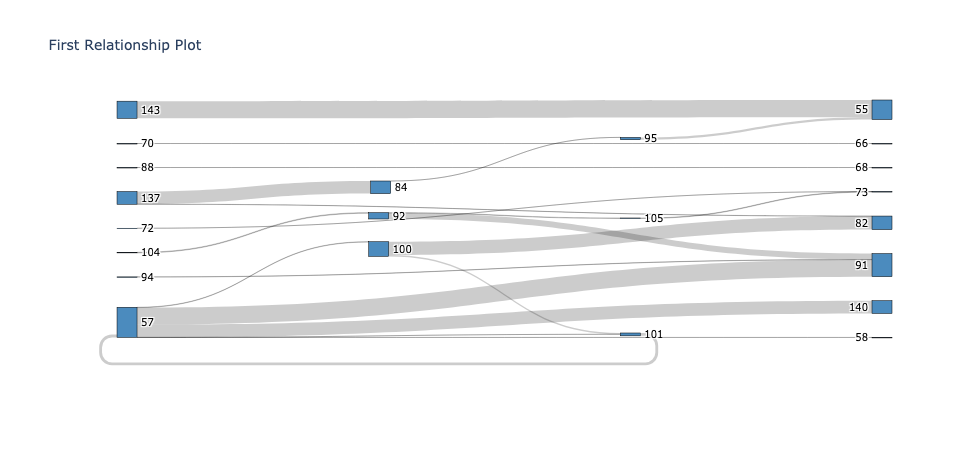

In [73]:
fig = genSankey(ds_1n_900s, cat_cols=['EventA', 'EventB'], value_cols='Delta', title='First Relationship Plot')
go.Figure(fig)        #plotly.offline.plot(fig, validate=False) - export to HTML

In [108]:
ds_12n_900s.head(n=5)

,EventA,EventB,EvA_Start,EvB_Start,EvA_End,EvB_End,Delta
1,67,100,2003-03-27 06:43:40,2003-03-27 06:44:06,2003-03-27 06:43:43,2003-03-27 07:12:41,-23
2,67,101,2003-03-27 06:43:40,2003-03-27 06:44:20,2003-03-27 06:43:43,2003-03-27 07:46:34,-37
3,67,57,2003-03-27 06:43:40,2003-03-27 06:44:35,2003-03-27 06:43:43,2003-03-27 06:44:48,-52
4,67,58,2003-03-27 06:43:40,2003-03-27 06:44:36,2003-03-27 06:43:43,2003-03-27 06:44:48,-53
5,67,67,2003-03-27 06:43:40,2003-03-27 06:44:49,2003-03-27 06:43:43,2003-03-27 06:44:56,-66


In [109]:
def add_DAY_WDWE_phaseII(ds):
    dayNumKeyWithDAYDict = pd.Series(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], ['0','1','2','3','4','5','6']).to_dict()
    dayNumKeyWithWDWEDict = pd.Series(['WD','WD','WD','WD','WD','WE','WE'], ['0','1','2','3','4','5','6']).to_dict()
    ds.set_index(ds.EvA_Start, inplace = True)
    ds.insert((len(ds.columns)), "DAY", ds.index.dayofweek.astype(str), True)
    ds.insert((len(ds.columns)), "WDWE", ds.index.dayofweek.astype(str), True)
    ds = ds.replace({"DAY": dayNumKeyWithDAYDict})
    ds = ds.replace({"WDWE": dayNumKeyWithWDWEDict})
    ds.reset_index(drop = True, inplace = True)
    return ds

In [110]:
ds_12n_900s = add_DAY_WDWE_phaseII(ds_12n_900s)

In [111]:
ds_12n_900s.head(n=5)

,EventA,EventB,EvA_Start,EvB_Start,EvA_End,EvB_End,Delta,DAY,WDWE
0,67,100,2003-03-27 06:43:40,2003-03-27 06:44:06,2003-03-27 06:43:43,2003-03-27 07:12:41,-23,Thu,WD
1,67,101,2003-03-27 06:43:40,2003-03-27 06:44:20,2003-03-27 06:43:43,2003-03-27 07:46:34,-37,Thu,WD
2,67,57,2003-03-27 06:43:40,2003-03-27 06:44:35,2003-03-27 06:43:43,2003-03-27 06:44:48,-52,Thu,WD
3,67,58,2003-03-27 06:43:40,2003-03-27 06:44:36,2003-03-27 06:43:43,2003-03-27 06:44:48,-53,Thu,WD
4,67,67,2003-03-27 06:43:40,2003-03-27 06:44:49,2003-03-27 06:43:43,2003-03-27 06:44:56,-66,Thu,WD


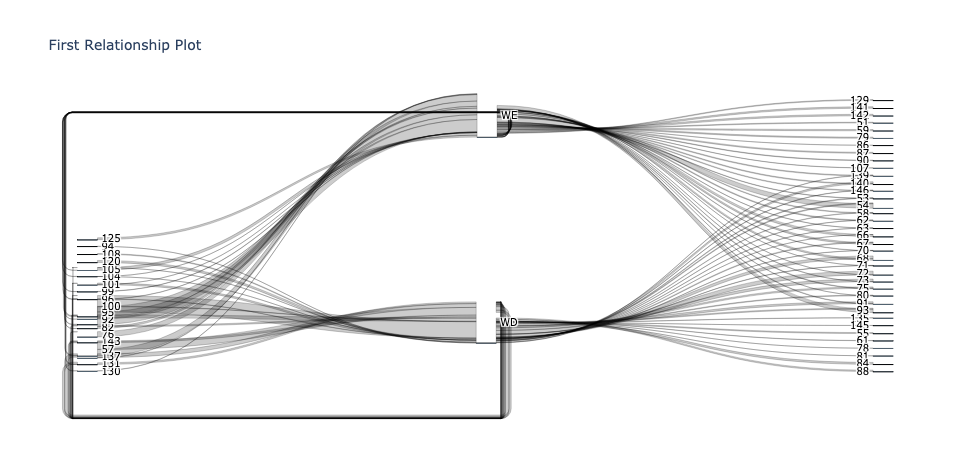

In [113]:
fig = genSankey(ds_12n_900s, cat_cols=['EventA', 'WDWE', 'EventB'], value_cols='Delta', title='First Relationship Plot')
go.Figure(fig) 

In [116]:
ds_5n_15s = add_DAY_WDWE_phaseII(ds_5n_15s)

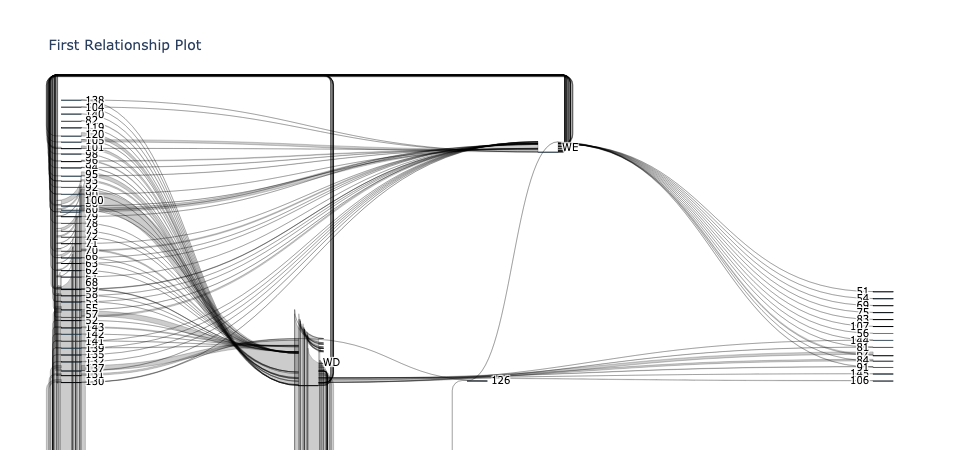

In [117]:
fig = genSankey(ds_5n_15s, cat_cols=['EventA', 'WDWE', 'EventB'], value_cols='Delta', title='First Relationship Plot')
go.Figure(fig)

In [119]:
fig = genSankey(ds_5n_15s, cat_cols=['EventA', 'EventB'], value_cols='Delta', title='First Relationship Plot')
go.Figure(fig)
plotly.offline.plot(fig, validate=False)

'temp-plot.html'

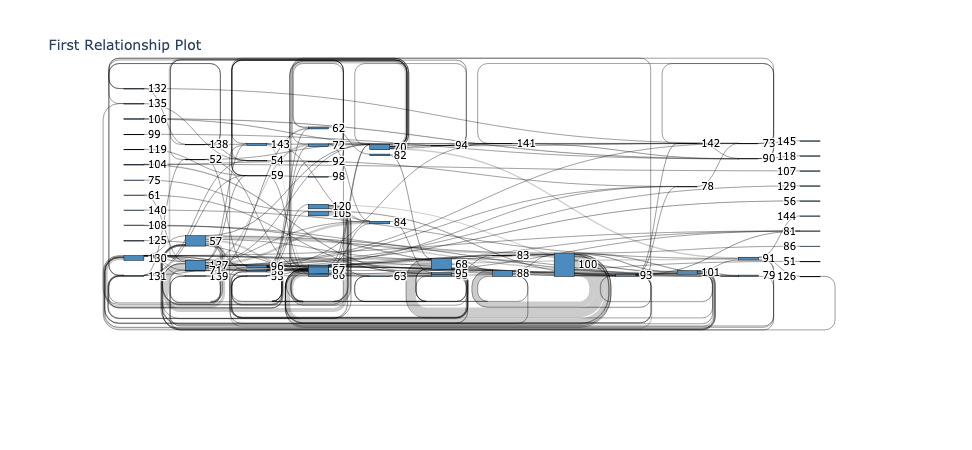

In [11]:
import plotly.offline as py
import plotly.graph_objs as go
fig = genSankey(ds_1n_25s, cat_cols=['EventA', 'EventB'], value_cols='Delta', title='First Relationship Plot')
py.iplot(go.Figure(fig))

In [1]:

#mesh = go.Mesh3d(x=[0,1,0],y=[0,0,1],z=[0,0,0],i=[0],j=[1],k=[2],flatshading=False,color='#333333')
#py.iplot([mesh])

In [43]:
from IPython.display import display

def Plotly(data=[], layout={}):
    bundle = {}
    bundle['application/vnd.plotly.v1+json'] = {
        'data': data,
        'layout': layout,
    }
    display(bundle, raw=True)

data = [
    {'x': [1999, 2000, 2001, 2002], 'y': [10, 15, 13, 17], 'type': 'scatter'},
    {'x': [1999, 2000, 2001, 2002], 'y': [16, 5, 11, 9], 'type': 'scatter'}
]

layout = {
    'title': 'Sales Growth',
    'xaxis': {'title': 'Year', 'showgrid': False, 'zeroline': False},
    'yaxis': {'title': 'Percent', 'showline': False}
}

#Plotly(data, layout)

In [9]:

def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [ ]:
fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    valuesuffix = "TWh",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  data['data'][0]['node']['label'],
      color =  data['data'][0]['node']['color']
    ),
    # Add links
    link = dict(
      source =  data['data'][0]['link']['source'],
      target =  data['data'][0]['link']['target'],
      value =  data['data'][0]['link']['value'],
      label =  data['data'][0]['link']['label']
  ))])

fig.update_layout(title_text="Energy forecast for 2050<br>Source: Department of Energy & Climate Change, Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
                  font_size=10)
fig.show()

In [ ]:
#https://medium.com/kenlok/how-to-create-sankey-diagrams-from-dataframes-in-python-e221c1b4d6b0

* 24till2
* 3till5
* 6till8
* 9till11
* 12till14
* 15till17
* 18till20
* 21till23